In [1]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score

In [2]:
train_csv = pd.read_csv("D:/Downloads/D/USTH/B3/Machine Learning in Medicine/HCG18/HCG18_Dataset/train_set_pixel_size_and_HC.csv")
train_dir = "D:/Downloads/D/USTH/B3/Machine Learning in Medicine/HCG18/HCG18_Dataset/train_set"

test_csv = pd.read_csv("D:/Downloads/D/USTH/B3/Machine Learning in Medicine/HCG18/HCG18_Dataset/test_set_pixel_size.csv")
test_dir = "D:/Downloads/D/USTH/B3/Machine Learning in Medicine/HCG18/HCG18_Dataset/test_set"

In [3]:
train_csv.head()


,filename,pixel size(mm),HC (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [4]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        999 non-null    object 
 1   pixel size(mm)  999 non-null    float64
 2   HC (mm)         999 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.5+ KB


In [5]:
test_csv.head()

,filename,pixel size(mm)
0,000_HC.png,0.235857
1,001_HC.png,0.067973
2,002_HC.png,0.165202
3,003_HC.png,0.096674
4,004_HC.png,0.202203


In [6]:
len(train_csv)


999

In [7]:
len(test_csv)

335

In [35]:

image_ids = train_csv["filename"]
hc_values = train_csv["HC (mm)"].values

In [38]:
def load_image(img_id): 
    img_path = os.path.join(train_dir, img_id + ".png")
    if not os.path.exists(img_path):
        return np.zeros((224, 224, 3), dtype=np.uint8)
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = preprocess_input(img)  
    return img

X_data = np.array([load_image(img_id) for img_id in image_ids])
y_data = np.array(hc_values)


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f" Train size: {X_train.shape}, Validation size: {X_val.shape}")

 Train size: (799, 224, 224, 3), Validation size: (200, 224, 224, 3)


In [42]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="linear")(x)  

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanAbsoluteError(), metrics=["mae"])

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [54]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 32, verbose = 1)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 46.6441 - mae: 46.6441 - val_loss: 44.2653 - val_mae: 44.2653
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 47.7514 - mae: 47.7514 - val_loss: 44.2344 - val_mae: 44.2344
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 47.6144 - mae: 47.6144 - val_loss: 44.2345 - val_mae: 44.2345
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 48.0138 - mae: 48.0138 - val_loss: 44.2436 - val_mae: 44.2436
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 50.5572 - mae: 50.5572 - val_loss: 44.2583 - val_mae: 44.2583
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 49.8698 - mae: 49.8698 - val_loss: 44.3357 - val_mae: 44.3357
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 49.5442 - mae: 49.5442 - val_loss: 44.3132 - val_mae: 44.3132
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 50.7696 - mae: 50.7696 - val_loss: 44.2358 - val_mae: 44.2358
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41

In [55]:
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)

mse = mean_squared_error(y_val, y_pred)

rmse = np.sqrt(mse)

r2 = r2_score(y_val, y_pred)

print(" Regression Model Evaluation:  ")
print(f" MAE  = {mae:.2f} mm")
print(f" MSE  = {mse:.2f}")
print(f" RMSE = {rmse:.2f}")
print(f" R² Score = {r2:.4f}")




7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
 Regression Model Evaluation:  
 MAE  = 44.46 mm
 MSE  = 4095.31
 RMSE = 63.99
 R² Score = -0.0152



Head Circumference (HC) Statistics (mm):
count    999.000000
mean     174.383093
std       65.282061
min       44.300000
25%      153.600000
50%      174.060000
75%      189.825000
max      346.400000
Name: HC (mm), dtype: float64


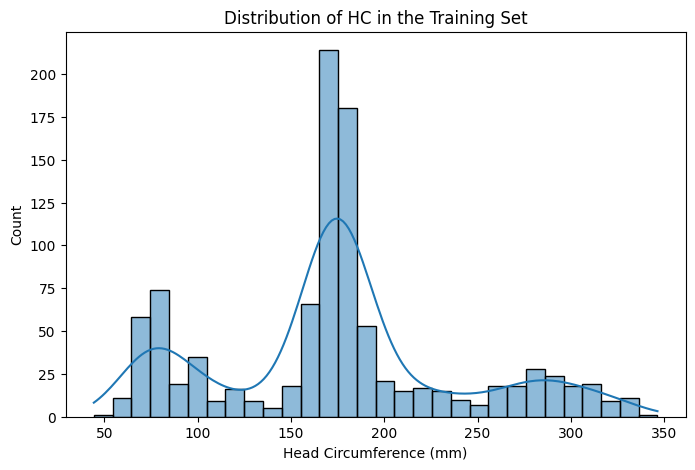

In [56]:
print("\nHead Circumference (HC) Statistics (mm):")
print(train_csv["HC (mm)"].describe())
 
plt.figure(figsize=(8, 5))
sns.histplot(train_csv["HC (mm)"], bins=30, kde=True)
plt.xlabel("Head Circumference (mm)")
plt.ylabel("Count")
plt.title("Distribution of HC in the Training Set")
plt.show()


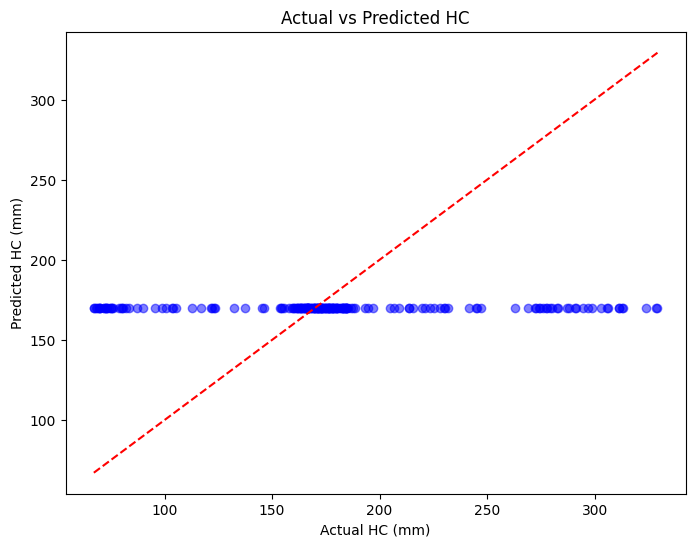

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red')  # Đường y=x
plt.xlabel("Actual HC (mm)")
plt.ylabel("Predicted HC (mm)")
plt.title("Actual vs Predicted HC")
plt.show()


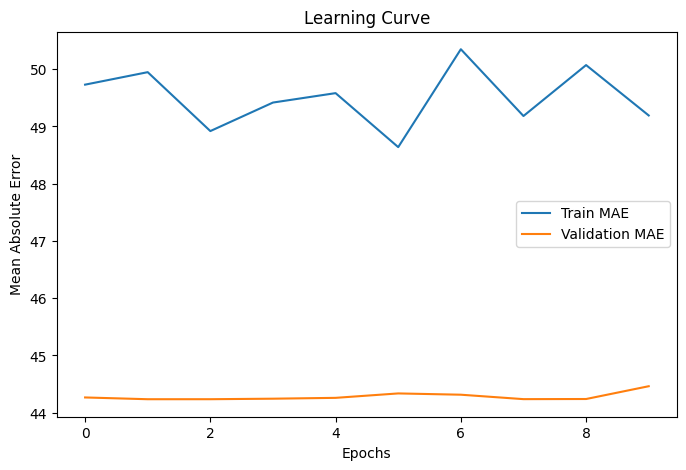

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

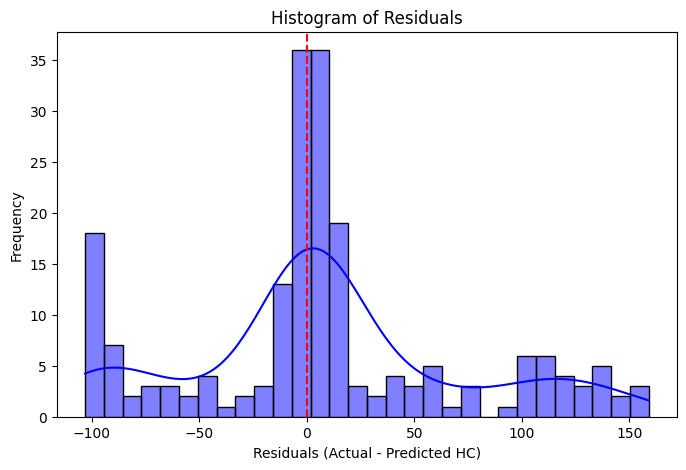

In [59]:
residuals = y_val - y_pred.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted HC)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


In [60]:
test_image_ids = test_csv["filename"]

X_test = np.array([load_image(img_id) for img_id in test_image_ids])

y_test_pred = model.predict(X_test)

test_csv["Predicted_HC (mm)"] = y_test_pred
test_csv.to_csv("predicted_test_HC.csv", index=False)




11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
